In [30]:
import re
from copy import deepcopy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import rcParams,style
rcParams['figure.figsize'] = 8.5,4.5
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sqlite3 import dbapi2 as sql3
pd.set_option('mode.chained_assignment', None)
style.use('seaborn')
import warnings
warnings.filterwarnings(action='once')
warnings.simplefilter(action="ignore", category=FutureWarning)

Write a wrapper to connect to the SQLite3 database.

In [2]:
#used to provide read-only access to the sqlite3 database
def query_db(query_str, db_name=None):
    if db_name is None:
        db_name = 'sport.db'
    db = sql3.connect(db_name)
    cursor = db.cursor()
    cursor.execute(query_str)
    
    #note that this doesn't set the index
    return pd.DataFrame(cursor.fetchall(),columns=[t[0] for t in cursor.description])

#get all the available data from the database
gms_aug_qry = '''
    SELECT all_gms.*
    , events.start_at AS event_date
    , events."key" --key is usually a reserved keyword, hence the ""
    FROM rounds AS rds
    INNER JOIN( --the subquery produces a table of all games
        SELECT gms.id
        ,gms.round_id
        ,gms.score1
        ,gms.score2
        ,t1.title AS team1
        ,t2.title AS team2
        FROM games AS gms
        INNER JOIN teams t1 ON gms.team1_id = t1.id
        INNER JOIN teams t2 ON gms.team2_id = t2.id
    ) AS all_gms
    ON rds.id = all_gms.round_id
    INNER JOIN events
    ON rds.event_id = events.id
    WHERE events.league_id < 17; --all the national team events
'''

gms_aug = query_db(gms_aug_qry)
#drop the matches with missing scorelines
gms_aug = gms_aug[(gms_aug['score1'].notnull())&(gms_aug['score2'].notnull())]

Even for all the available match data (as well as for all the world cup data), there is a significant discrepancy between the teams on the LHS and the RHS, implying they are from different distributions. After a bit of digging around, it appears there's [seeding](https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_seeding) (which I didn't know about previously), and seeded teams more often appear on the left.

Interestingly, seeded teams also appear on the right sometimes, but on this list [here](https://en.wikipedia.org/wiki/2018_FIFA_World_Cup), seeds appear twice on the left in the group stages. Another thing to note is that not all teams that appear twice on the left are seeds, since there are only 8 seeded teams, accounting for 1/4 of all the teams.

In [3]:
gms_aug['key'].unique()
display(gms_aug.describe())

,id,round_id,score1,score2
count,1931.000000,1931.000000,1931.000000,1931.000000
mean,971.133610,197.440704,1.638529,1.119109
std,562.310999,158.383283,1.560140,1.267490
min,1.000000,1.000000,0.000000,0.000000
25%,485.500000,44.000000,1.000000,0.000000
50%,968.000000,174.000000,1.000000,1.000000
75%,1450.500000,343.500000,2.000000,2.000000
max,1955.000000,504.000000,10.000000,10.000000


It's natural to suspect there might be some form of seeding for the qualifiers as well, and sure enough, according to [Wikipedia](https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_qualification_%28UEFA%29) this is indeed the case, although there doesn't seem to be any easily identifiable patterns to the way they appear.

For the 2014 World Cup qualifiers, interestingly there no teams that appear twice on the left (possibly some effect caused by the number of qualifying rounds). However, there are plenty of teams that appear 3, 4 (and one that appears 5 times), while the rest only appear once. Unfortunately, each team appears exactly the same number of times on the left as on the right.

In [4]:
quali = gms_aug[gms_aug['key']=='world.quali.africa.2014']
team1_counts, team2_counts = quali.groupby('team1').size(),quali.groupby('team2').size()
display(team1_counts.groupby(team1_counts).size())
display(pd.concat([team1_counts, team2_counts],axis=1))

1    11
3    20
4    19
5     1
dtype: int64

,0,1
Algeria,4,4
Angola,3,3
Benin,3,3
Botswana,3,3
Burkina Faso,4,4
Burundi,1,1
Cameroon,4,4
Cape Verde,3,3
Central African Republic,3,3
Chad,1,1


So training two separate models, one for team1 (pool containing seeded teams) and another for team2 (pool of unseeded teams) seems to make sense. However, in practice this means training two models on data sets of half the size - which significantly impacts performance.

Another tac might be to train on a cleaned-up data set, but it may not be clear how to map the teams to team1 or team2, especially for qualifiers and predictions. 

Ideally we'd have the seedings and have them as input features into the model, but this is out-of-scope for the moment since inputting such data is a significant undertaking on its own, if the data is not already available.

The timezone information is taken from https://en.wikipedia.org/wiki/List_of_time_zones_by_country. For countries spread across multiple time zones, assign the main time zone as the time zone that most of the state is in; for countries for which this is not applicable, use the time zone for the capital instead.  Check to see which teams will still be missing timezone information after this.

In [5]:
raw_tz_df = pd.read_excel('raw_tz.xlsx')
raw_tz_df.columns = ['state', 'num_time_zone', 'main_time_zone']

#clean up the data slightly, and figure out which teams still have missing time zones
gms_aug['team1'] = gms_aug['team1'].str.strip().str.lower()
gms_aug['team2'] = gms_aug['team2'].str.strip().str.lower()
team1, team2 = gms_aug['team1'].str.strip().str.lower(), gms_aug['team2'].str.strip().str.lower()
wc_teams = set(team1)|set(team2)
missing_tz = wc_teams - set(raw_tz_df['state'].str.strip().str.lower())

Output the teams missing time zone information into a spreadsheet for manual labelling.

In [6]:
missing_tz = pd.Series(list(missing_tz))
missing_tz.to_frame().to_excel('missing_tz.xlsx',index=False)
display(missing_tz.to_frame().head())

,0
0,american samoa
1,palestine
2,latvija
3,guadeloupe
4,wales


Compute the clean time zone

In [7]:
filled_tz_df = pd.read_excel('filled_tz.xlsx')
all_tz_df = pd.concat([raw_tz_df, filled_tz_df])
all_tz_df['clean_time_zone'] = all_tz_df['main_time_zone'].apply(lambda r: int(r[3:6].replace('−','-')))
all_tz_df.to_excel('alltz.xlsx')

Use the info from https://en.wikipedia.org/wiki/List_of_FIFA_World_Cup_finals to figure out the time zones of the host countries.

In [8]:
gms_fnl = pd.read_excel('final_matches.xlsx')
gms_fnl['host_country'] = gms_fnl['Location'].apply(
    lambda r: r[r.find(',')+1:].strip().lower())
time_map = dict(zip(all_tz_df['state'].str.lower().str.strip(),all_tz_df['clean_time_zone']))

gms_fnl['Winners'] = gms_fnl['Winners'].str.lower().str.strip()
gms_fnl['Runners-up'] = gms_fnl['Runners-up'].str.lower().str.strip()

#standardise naming of these teams
gms_fnl.replace('west germany','east germany (-1989)',inplace=True)
gms_fnl.replace('czechoslovakia','czechoslovakia (-1992)',inplace=True)

#compute the time zones of these games
gms_fnl['winners_tz'] = gms_fnl['Winners'].map(time_map)
gms_fnl['runners_up_tz'] = gms_fnl['Runners-up'].map(time_map)
gms_fnl['time_zone'] = gms_fnl['host_country'].map(time_map)

tz_fnl = gms_fnl[['Year','time_zone']]
display(tz_fnl)

,Year,time_zone
0,1930,-3
1,1934,1
2,1938,1
3,1950,-3
4,1954,1
5,1958,1
6,1962,-4
7,1966,0
8,1970,-6
9,1974,1


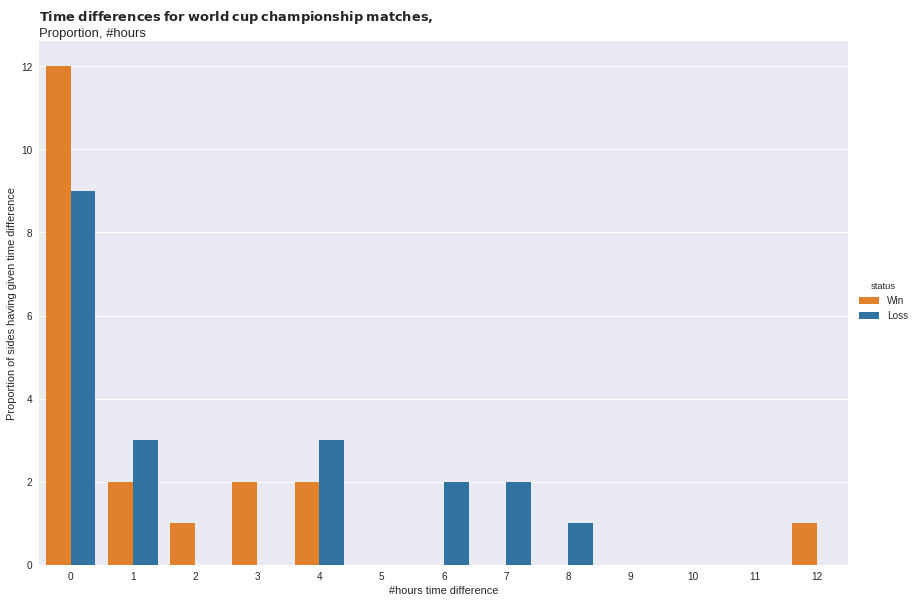

In [39]:
#compute the time differences
gms_fnl['tz_diff_winners'] = np.mod(np.abs(gms_fnl['winners_tz'].convert_objects(convert_numeric=True)
                                  - gms_fnl['time_zone']),13)
gms_fnl['tz_diff_runners_up'] = np.mod(np.abs(gms_fnl['runners_up_tz'].convert_objects(convert_numeric=True)
                                  - gms_fnl['time_zone']),13)

#alternative way of plotting using pandas instead
def plot_tz(colnames, df):
    plot_df = pd.DataFrame()
    for colname in colnames:
        tz_diff = {}
        for i in range(13):
            tz_diff[i] = len(df[df[colname]==i])
        tz_diff = pd.Series(tz_diff).rename(colname).to_frame()
        if len(plot_df) == 0:
            plot_df = tz_diff
        else:
            plot_df = pd.concat([plot_df,tz_diff],axis=1)
    mpl.style.use('seaborn')
    ax = plot_df.plot(kind='bar',colormap='tab20')
    plt.show()
# plot_tz(['tz_diff_winners','tz_diff_runners_up'],gms_fnl)    

#plotting through seaborn
plot_df = pd.DataFrame()    
for colname in ['tz_diff_winners','tz_diff_runners_up']:
    tz_diff = {}
    for i in range(13):
        tz_diff[i] = len(gms_fnl[gms_fnl[colname]==i])
    tz_diff = pd.Series(tz_diff).rename('Teams').to_frame()
    if len(plot_df) == 0:
        plot_df = tz_diff
    else:
        plot_df = pd.concat([plot_df.assign(status='Win'),tz_diff.assign(status='Loss')],axis=0)
    plot_df.reset_index(inplace=True)

pal = sns.color_palette('tab20')
blues = sns.color_palette('Blues')
plot_df = plot_df.sort_values('status',ascending=False)
g = sns.factorplot(y='Teams',x='level_0',hue='status',data=plot_df,
               size=8,aspect=1.5,kind='bar',palette=(pal[2], pal[0]))
g.despine(left=True)
g.set_ylabels('Proportion of sides having given time difference')
g.set_xlabels('#hours time difference')
g.axes.flatten()[0].set_title(r'''$\bf{Time\:differences\:for\:world\:cup\:championship\:matches,}$
Proportion, #hours''',ha='left',position=(0,1),size=13)
plt.savefig('tz_diff_ch.jpg')
plt.show()

Calculate the time difference for both teams. If you think about it, for your body clock, the time difference can't go really go above 12 - anything beyond 12 hours will be 'closer' to another day. This means that we'll need a subtraction (and in fact the absolute value from this) and a modulo operation, for example we don't consider GMT +9 and GMT -5 to be 14 hours different, but 10 hours different. Similarly, flights don't normally go the long way around, but whichever direction is the shortest.

In [10]:
gms_aug['event_year'] = gms_aug.apply(lambda r: int(r['event_date'][:4]), axis=1)
gms_aug['wc_year'] = gms_aug.apply(lambda r: int(r['key'][-4:]), axis=1)
gms_aug = pd.merge(gms_aug, tz_fnl, how='left', left_on='event_year', right_on='Year')

gms_aug['tz_team1'] = gms_aug['team1'].str.lower().str.strip().map(time_map)
gms_aug['tz_team2'] = gms_aug['team2'].str.lower().str.strip().map(time_map)

gms_aug['tz_diff_team1'] = np.mod(np.abs(gms_aug['tz_team1'].convert_objects(convert_numeric=True)
                                  - gms_aug['time_zone']),13)
gms_aug['tz_diff_team2'] = np.mod(np.abs(gms_aug['tz_team2'].convert_objects(convert_numeric=True)
                                  - gms_aug['time_zone']),13)

gms_aug = gms_aug[['id','key','score1','score2','team1','team2',
                   'event_year','wc_year','tz_diff_team1','tz_diff_team2']]

Now that we've some extra data, `gms_aug` holds all available match data (including from non- World Cup games). Similarly, `gms_exc_14_aug` holds all match data excepting the 2014 world cup matches. As before, `gms_all` holds all world cup match data, `gms_10` holds only 2010 worldcup data, `gms_14` holds only 2014 world cup data, while `gms_exc_14` holds all world cup data excluding the 2014 match data. 

In [11]:
def get_gms_df(gms_aug):
    gms_wc = gms_aug.loc[gms_aug['key'].apply(lambda x: 
        False if re.compile(r'^(world.\d\d\d\d)$').search(x) is None else True)]
    gms_all = gms_wc.loc[gms_wc['key']!='world.2018']
    gms_10 = gms_all.loc[gms_all['key']=='world.2010']
    gms_14 = gms_all.loc[gms_all['key']=='world.2014']
    gms_exc_14_aug = gms_aug[(gms_aug['key']!='world.2014')&(gms_aug['key']!='world.confed.2017')
                            &(gms_aug['key']!='world.2018')]
    gms_exc_14 = gms_all[gms_all['key']!='world.2014']
    return gms_wc, gms_all, gms_10, gms_14, gms_exc_14_aug, gms_exc_14

gms_wc, gms_all, gms_10, gms_14, gms_exc_14_aug, gms_exc_14 = get_gms_df(gms_aug)

Now to check what the distribution of the time difference looks like for world cup teams in general. Plot the histogram of differences in time zones for all teams that participated in historical world cup matches.

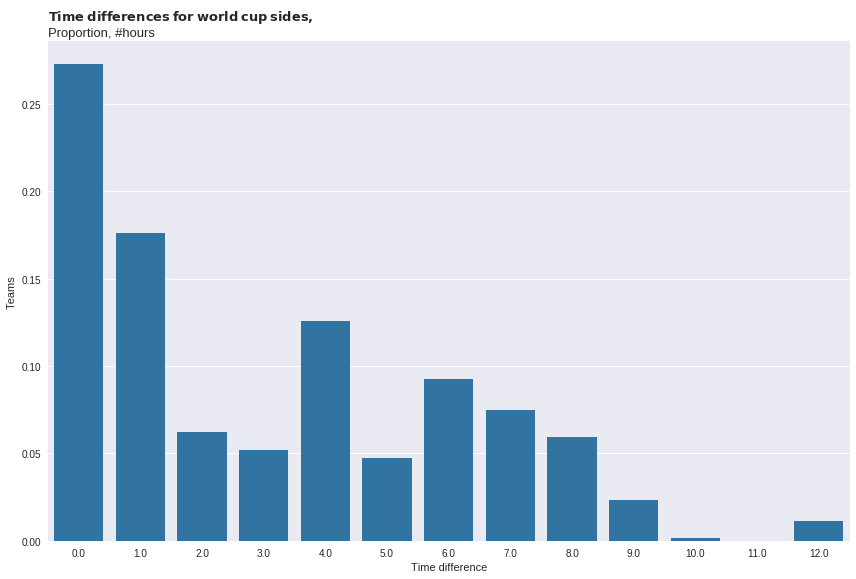

In [40]:
tz_diff_team1 = gms_all['tz_diff_team1'].groupby(gms_all['tz_diff_team1']).count()
tz_diff_team2 = gms_all['tz_diff_team2'].groupby(gms_all['tz_diff_team2']).count()
tz_diff_teams = tz_diff_team1 + tz_diff_team2
tz_diff_teams /= tz_diff_teams.sum()
tz_diff_teams = pd.Series(tz_diff_teams).to_frame()
tz_diff_teams.columns = ['tz_diff_teams']

#set the colour of the bars
pal = sns.color_palette('tab20')
g = sns.factorplot(y='tz_diff_teams', x=tz_diff_teams.index, data=tz_diff_teams,
                   size=8,aspect=1.5,kind='bar',color=pal[0])
g.despine(left=True)
g.set_ylabels('Teams')
g.set_xlabels('Time difference')
g.axes.flatten()[0].set_title(r'''$\bf{Time\:differences\:for\:world\:cup\:sides,}$
Proportion, #hours''',ha='left',position=(0,1),size=13)
plt.savefig('tz_diff_wc.jpg')
plt.show()

It's quite clear that teams making it to the finals generally have a smaller time difference - even more so for the eventual champions.

Compare the differences in time zone for winning, drawing and losing teams.

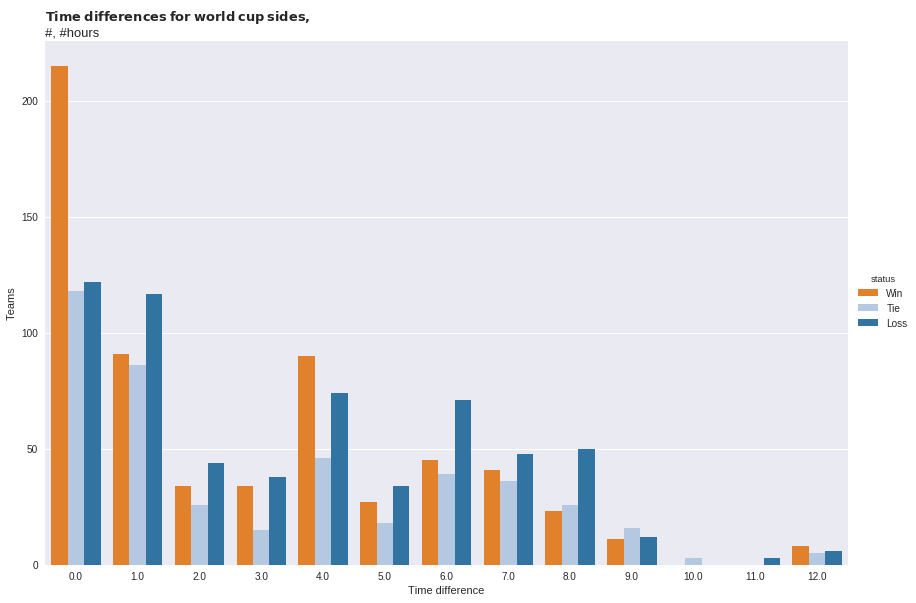

In [41]:
#create a flattened dataframe to hold all scorelines twice, once with team A as team1, another with team B as team1
gms_tz_flat = pd.concat([gms_all.rename(columns={'tz_diff_team1':'tz_diff'}),gms_all.rename(columns={
    'tz_diff_team2':'tz_diff','team1':'team2','team2':'team1', 'score1':'score2','score2':'score1'})])
gms_tz_flat = gms_tz_flat[['event_year','team1','team2','score1','score2','tz_diff']]

gms_tz_flat.loc[gms_tz_flat['score1']>gms_tz_flat['score2'],'status'] = 'Win'
gms_tz_flat.loc[gms_tz_flat['score1']==gms_tz_flat['score2'],'status'] = 'Tie'
gms_tz_flat.loc[gms_tz_flat['score1']<gms_tz_flat['score2'],'status'] = 'Loss'

tz_diff_count = gms_tz_flat.groupby(['tz_diff','status']).size().rename('tz_diff_count').to_frame()
tz_diff_count.reset_index(inplace=True)

tz_diff_count.sort_values('status',inplace=True, ascending=False)
# Draw a clustered barplot to compare distributions of time zone differences for winning, drawing and losing sides
g = sns.factorplot(x='tz_diff', y='tz_diff_count', hue='status', data=tz_diff_count,
                   size=8,aspect=1.5, kind='bar', palette=(pal[2],pal[1], pal[0]))
g.despine(left=True)
g.axes.flatten()[0].set_title(r'''$\bf{Time\:differences\:for\:world\:cup\:sides},$
#, #hours''',ha='left',position=(0,1),size=13)
g.set_ylabels('Teams')
g.set_xlabels('Time difference')
plt.savefig('tz_diff_results.jpg')
plt.show()

Is the above simply due to the home-advantage effect? It might be worthwhile to see if this is the case by removing the hosts from the matches included (although we won't go into that for now). The peak at 4.0 corresponds to the time difference between much of Europe and the Americas.

Rewrite the wrapper function to allow easier extensibility, and a flag to indicate the type of prediction. In the event of previously unseen teams, resort to using the arithmetic means.

In [14]:
def pred_team_gls(model, match_record, gls_df, have_teams=None, params=None):

    #the following initialise when first run
    if have_teams is None: 
        #get the teams whose games we've seen
        have_teams = set(gls_df['team1'])|set(gls_df['team2'])
    if params is None:
        #get names of the variables in the model
        var_regex = re.compile(r'([^[])*([.*])*')
        params = set([var_regex.search(v).group() for v in model.params.index[1:]])

    team1,team2 = match_record['team1'], match_record['team2']
    
    if team1 in have_teams:
        if team2 in have_teams:
            #have data for both teams
            pred_type = 'no_miss'
            data = match_record[params]
            pred1 = model.predict(pd.DataFrame(data=dict(data),index=[0])).values[0]
            #now output predictions for team two
            data = data.rename({'team1':'team2','team2':'team1'})
            pred2 = model.predict(pd.DataFrame(data=dict(data),index=[0])).values[0]
        else:
            #team2 data missing
            pred_type = 't2_miss'
            team1_gls = gls_df.loc[gls_df['team1']==team1,'score']
            pred1, pred2 = team1_gls.mean(), gls_df['score'].mean()
    
    elif team2 in have_teams:
        #team1 data missing
        pred_type = 't1_miss'
        team2_gls = gls_df.loc[gls_df['team1']==team2,'score']                 
        pred1, pred2 = gls_df['score'].mean(), team2_gls.mean()
    else:
        #data missing for both teams
        pred_type = 'both_miss'
        pred1, pred2 = gls_df['score'].mean(), gls_df['score'].mean()
    
    return np.round(pred1,8), np.round(pred2,8), pred_type

Write a wrapper for the evaluation of predictions.

In [15]:
def eval_preds(pred_df, score1='score1', score2='score2',
                        pred1='pred1', pred2='pred2'):
    score1_mae = mae(pred_df[score1], pred_df[pred1])
    score2_mae = mae(pred_df[score2], pred_df[pred2])
    return score1_mae, score2_mae, (score1_mae+score2_mae)/2

In [16]:
gls_df = pd.concat([gms_exc_14_aug.rename(columns={'score1':'score'}),
    gms_exc_14_aug.rename(columns={'score2':'score','team1':'team2','team2':'team1'})])
gls_df.dropna(subset=['score'],inplace=True)
gls_df.describe()

,event_year,id,score,score1,score2,tz_diff_team1,tz_diff_team2,wc_year
count,3650.000000,3650.000000,3650.000000,1825.000000,1825.000000,1544.000000,1544.000000,3650.000000
mean,1999.088767,957.582466,1.380000,1.656438,1.103562,2.911917,3.308290,2000.255342
std,20.186057,564.397925,1.453579,1.577596,1.259052,3.015624,3.038877,20.921456
min,1930.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1930.000000
25%,1990.000000,459.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1990.000000
50%,2011.000000,979.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2013.000000
75%,2011.000000,1435.000000,2.000000,2.000000,2.000000,5.000000,6.000000,2014.000000
max,2016.000000,1939.000000,10.000000,10.000000,10.000000,12.000000,12.000000,2016.000000


Need to 'mirror' all the matches due to symmetry before fitting the model.

In [17]:
class avg_model():
    def __init__(self,gms_df):
        self.avgs = {}
        have_teams = set(gms_df['team1'])|set(gms_df['team2'])
        self.params = pd.Series(index=['intercept','team1', 'team2'])
        for team in have_teams:
            gls_df = pd.concat([gms_df.loc[gms_df['team1']==team,'score1'],
                                gms_df.loc[gms_df['team2']==team,'score2']])
            self.avgs[team] = gls_df.mean()

            
    def predict(self,data,*args,**kwargs):
        team = data.loc[0,'team1']
        return pd.Series(self.avgs[team])

    
#fit the models
def eval_models(train, test): 
    gls_df = pd.concat([train.rename(columns={'score1':'score'}),
        train.rename(columns={'score2':'score','team1':'team2','team2':'team1'})])
    gls_df.dropna(subset=['score'],inplace=True)

    poi_v1 = smf.glm(formula="score ~ team1 + team2", data=gls_df,
                            family=sm.families.Poisson()).fit(method='nm')
    nbin_v1 = smf.glm(formula="score ~ team1 + team2", data=gls_df, 
                            family=sm.families.NegativeBinomial()).fit(method='nm')

    poi_v2 = smf.glm(formula="score ~ team1 + team2 + tz_diff_team1 + tz_diff_team2", data=gls_df, 
                            family=sm.families.Poisson()).fit(method='nm')
    nbin_v2 = smf.glm(formula="score ~ team1 + team2 + tz_diff_team1 + tz_diff_team2", data=gls_df, 
                            family=sm.families.NegativeBinomial()).fit(method='nm')
    hist_avg = avg_model(train)
    
    evals = []
    for model, name in [(poi_v1,'poi_v1'), (nbin_v1, 'nbin_v1'), (poi_v2, 'poi_v2'), (nbin_v2, 'nbin_v2'),
                        (hist_avg, 'hist_avg')]:
        preds = test.apply(lambda r: pred_team_gls(model, r, gls_df=gls_df), axis=1).apply(pd.Series)
        test[name+'_pred1'], test[name+'_pred2'], test['pred_type'] = preds[0], preds[1], preds[2]
        evals.append(eval_preds(test, pred1=name+'_pred1', pred2=name+'_pred2')+(name,))
        
    evals = pd.DataFrame(evals, columns=['score1_mae', 'score2_mae', 'combined_mae','name'])
    evals.set_index('name',inplace=True)
    return test, evals

test_df,evals = eval_models(gms_exc_14, gms_14)
display(evals)

/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,score1_mae,score2_mae,combined_mae
name,,,
poi_v1,1.027292,1.259165,1.143229
nbin_v1,1.021716,1.251993,1.136854
poi_v2,1.036790,1.257300,1.147045
nbin_v2,1.029888,1.254225,1.142056
hist_avg,0.960364,1.172576,1.066470


In [18]:
key = pd.Series([123])
key.values[0]

123

It's promising that the error is still going down. But how performant are the models in practice?

In [19]:
test_df['err1'] = np.abs(test_df['nbin_v2_pred1']-test_df['score1'])
test_df['err2'] = np.abs(test_df['nbin_v2_pred2']-test_df['score2'])
pred_type_df = test_df[['pred_type','err1', 'err2']].groupby(test_df['pred_type']).mean()
pred_type_df['count'] = test_df[['pred_type']].groupby(test_df['pred_type']).count()
display(pred_type_df)

,err1,err2,count
pred_type,,,
no_miss,1.045447,1.281797,61
t1_miss,1.626295,0.333333,1
t2_miss,0.257143,0.873705,2


Notice how the errors for games missing team information, where we are using historical means only, actually end up with less error. It's clear that some categories are harder for the model to predict than others - in particular, the scorelines of team2.

Next, we'll use historical data to generate predictions on the last 3 World Cups, to evaluate how the models do in a more general setting.

In [20]:
all_evals = pd.DataFrame()

years = sorted(gms_all['event_year'].unique())
for year in years[17:]:
    display('event year is {}'.format(year))
    event_name = 'World.'+str(year)
    train = gms_all[gms_all['event_year']<year]
    test = gms_all[gms_all['event_year']==year]
    test_df,evals = eval_models(train, test)
    evals = evals.assign(year=year)
    if len(all_evals) == 0:
        all_evals = evals
    else:
        all_evals = pd.concat([all_evals, evals],axis=0,copy=False)

'event year is 2006'

/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


'event year is 2010'

/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


'event year is 2014'

/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zw10/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
eval_summary = all_evals.groupby(all_evals.index).mean()[['score1_mae','score2_mae','combined_mae']]
eval_summary.sort_values('combined_mae',ascending=True)

,score1_mae,score2_mae,combined_mae
name,,,
hist_avg,1.011719,0.965958,0.988838
poi_v1,1.083255,1.014120,1.048687
poi_v2,1.089382,1.023019,1.056200
nbin_v1,1.095616,1.024494,1.060055
nbin_v2,1.101271,1.034221,1.067746


It seems extremely hard to beat the historical averages model (so perhaps adding them in as input features into the model makes sense). On the other hand,there is a fault with them that we'll see later...

Now use the all the available World Cup data to predict results for the 2018 matches, including the 2017 world conferation data.

In [24]:
gms_con = gms_aug[gms_aug['key']=='world.confed.2017']
gms_con['time_zone'] = time_map['russia']
gms_con['tz_team1'] = gms_con['team1'].str.lower().str.strip().map(time_map)
gms_con['tz_team2'] = gms_con['team2'].str.lower().str.strip().map(time_map)
gms_con['tz_diff_team1'] = np.mod(np.abs(gms_con['tz_team1'].convert_objects(convert_numeric=True)
                                  - gms_con['time_zone']),13)
gms_con['tz_diff_team2'] = np.mod(np.abs(gms_con['tz_team2'].convert_objects(convert_numeric=True)
                                  - gms_con['time_zone']),13)
gms_all_con = pd.concat([gms_all,gms_con])
gls_all_con = pd.concat([gms_all_con.rename(columns={'score1':'score'}),
                    gms_all_con.rename(columns={'score2':'score','team1':'team2','team2':'team1'})])
regr_all = avg_model(gls_all_con)
preds = gms_18_raw.apply(lambda r: pred_team_gls(regr_all, r, gls_df=gls_all_con), axis=1).apply(pd.Series)
gms_18_raw['pred1'] = np.round(preds[0],0)
gms_18_raw['pred2'] = np.round(preds[1],0)
gms_18_raw[['team1','team2','score1','score2','pred1','pred2']]

,team1,team2,score1,score2,pred1,pred2
0,russia,saudi arabia,5.0,0.0,1.0,2.0
1,egypt,uruguay,0.0,1.0,1.0,1.0
2,russia,egypt,NaN,NaN,1.0,1.0
3,uruguay,saudi arabia,NaN,NaN,1.0,2.0
4,uruguay,russia,NaN,NaN,1.0,1.0
5,saudi arabia,egypt,NaN,NaN,2.0,1.0
6,morocco,iran,0.0,1.0,1.0,1.0
7,portugal,spain,3.0,3.0,1.0,1.0
8,portugal,morocco,NaN,NaN,1.0,1.0
9,iran,spain,NaN,NaN,1.0,1.0


In [25]:
pred_draws = gms_18_raw[gms_18_raw['pred1']==gms_18_raw['pred2']].shape[0]
display('{}/{} games are predicted to be draws'.format(pred_draws,len(gms_18_raw)))
hist_draws = gms_all[gms_all['score1']==gms_all['score2']].shape[0]
display('even though historically only {}/{} games were draws'.format(hist_draws,len(gms_all)))

'37/48 games are predicted to be draws'

'even though historically only 217/836 games were draws'

This just indicates that the MAE isn't a great metric to use if we want to predict the correct result directionally. It overrates the historical model simply because it's relatively well-calibrated but hopeless in terms of the resolution of its predictions. Of course, in the World Cup, and especially in the elimination stages, it's the win that matters, and not the goal count. 

Instead, something like the Brier Score may be more suitable metric(though sometimes small sample sizes will cause challenges) to figure out if the model is doing well in its win/loss predictions.  More on that in the next post, but for now...

In [28]:
nbin_model = smf.glm(formula="score ~ team1 + team2 + tz_diff_team1 + tz_diff_team2", data=gls_all_con, 
                        family=sm.families.Poisson()).fit()
poi_model = smf.glm(formula="score ~ team1 + team2 + tz_diff_team1 + tz_diff_team2", data=gls_all_con, 
                        family=sm.families.NegativeBinomial()).fit()

#technically both France and Croatia are only  1 hour different from Moscow right now 
#however, 2 maintains consistency with the training set
last_matches = pd.read_excel('last_matches.xlsx')
preds = last_matches.apply(lambda r: pred_team_gls(nbin_model, r, gls_df=gls_all_con), axis=1).apply(pd.Series)
last_matches['nbin_pred1'] = np.round(preds[0],1)
last_matches['nbin_pred2'] = np.round(preds[1],1)
preds = last_matches.apply(lambda r: pred_team_gls(nbin_model, r, gls_df=last_matches), axis=1).apply(pd.Series)
last_matches['poi_pred1'] = np.round(preds[0],1)
last_matches['poi_pred2'] = np.round(preds[1],1)

last_matches[['team1','team2','poi_pred1','poi_pred2','nbin_pred1','nbin_pred2']]

,team1,team2,poi_pred1,poi_pred2,nbin_pred1,nbin_pred2
0,england,belgium,1.3,0.6,1.3,0.6
1,france,croatia,1.3,1.0,1.3,1.0


The models output similar predictions (as do the base models without the time difference) - France and England, both past winners, are favourites over Belgium and Croatia. Bing favours Belgium - which will be right?